In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from collections import OrderedDict
from tqdm import tqdm

In [2]:
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from model_v2 import *
from bool_data_gen import *

In [4]:
%load_ext autoreload
%autoreload 2

## Data Gen

In [5]:
# Checks if all the values of the two tensors are close together, using torch.isclose()

def checkTensorClose(tensor1, tensor2, atol):
    val_close = torch.sum(torch.isclose(tensor1, tensor2, atol=atol))
    bool_val = torch.sum(val_close) == torch.numel(tensor1)
    return bool_val.item()

In [6]:
# This allows you to look into trainloader and the data returned.

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
i1, l1 = next(iter(trainloader))
print(torch.max(X_train))
print(torch.min(X_train))
print(torch.max(y_train))
print(torch.min(y_train))

NameError: name 'train_data' is not defined

In [7]:
# Normalized training data from get_train_data()
X_train, y_train = get_train_data([5000, 5000])

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

print(cache["X_train_mean"])

[1.48978987 1.50816063]


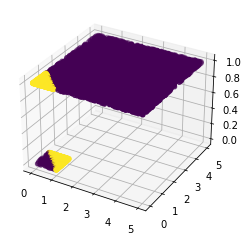

In [8]:
# Plotting the training data, unstandardized
X_train_orig = unstandardize_data(X_train, cache["X_train_mean"], cache["X_train_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_train_orig[:, 0], X_train_orig[:, 1], y_train, c=X_train[:,2])
# plt.xlim(0,1)
# plt.ylim(0,1)

## Model

In [9]:
def get_num_correct(labels, preds):
    preds = get_pred_class(preds)
    return (labels == preds).float().sum()

In [10]:
def get_pred_class(preds):
    return (preds > 0.5).float()

In [11]:
emb_dims = [2,8]

# Always keep batch size in powers of 2, trainloader works faster this way.
batch_size = 256
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
num_batches = math.ceil(1.0 * len(train_data) / batch_size)

In [12]:
model = WangNet(emb_dims=emb_dims, no_of_cont=2, lin_layer_sizes=[8, 16, 8, 4], \
                output_size=1, hidden_drop_p=0, batch_flag=False)

n_epochs = 100
loss_values = []
acc_values = []

pos_weight = torch.FloatTensor([np.count_nonzero(y_train==0), np.count_nonzero(y_train==1)])/len(y_train)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

t = tqdm(range(1, n_epochs+1), miniters=100)
for epoch in t:
    total_loss = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        cont_x = inputs[:,:2].float()
        cat_x = inputs[:,2].long()

        optimizer.zero_grad()
        
        preds = model(cont_x, cat_x)

        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        # scheduler.step()
        correct += get_num_correct(labels, preds)

    acc = correct/len(train_data)
    t.set_description(f"-----Epoch: {epoch}/{n_epochs}, Loss: {total_loss/num_batches}, Accuracy: {acc}-----")
    loss_values.append(total_loss/num_batches)
    acc_values.append(acc)

-----Epoch: 100/100, Loss: 0.008389645168790594, Accuracy: 0.9973000288009644-----: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


Text(0, 0.5, 'Training loss')

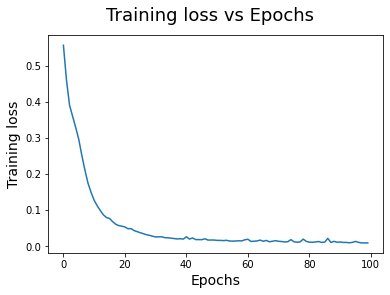

In [13]:
plt.plot(np.array(np.arange(0, n_epochs)), loss_values)
plt.suptitle('Training loss vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training loss', fontsize=14)

Text(0, 0.5, 'Training accuracy')

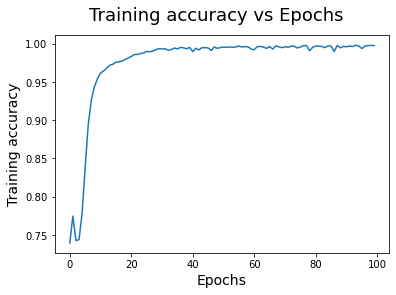

In [14]:
plt.plot(np.array(np.arange(0, n_epochs)), acc_values)
plt.suptitle('Training accuracy vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training accuracy', fontsize=14)

Total Accuracy on test split A: 1.0


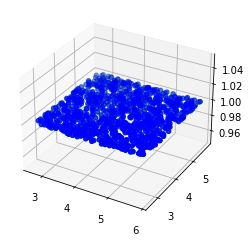

In [15]:
# Testing Split A
X_testA, y_testA = get_test_splitA(1000)

X_testA = torch.tensor(X_testA).float()
y_testA = torch.tensor(y_testA).view(-1, 1).float()

with torch.no_grad():
    predsA = model(X_testA[:,:2].float(), X_testA[:,2].long())
    total_acc = get_num_correct(y_testA, predsA) / len(X_testA)
print(f"Total Accuracy on test split A: {total_acc}")
    
# Comment this line out to see the non-classification predictions.
predsA = get_pred_class(predsA)

X_testA_orig = unstandardize_data(X_testA, cache["X_testA_mean"], cache["X_testA_std"])
ax = plt.axes(projection='3d')
ax.scatter3D(X_testA_orig[:, 0], X_testA_orig[:, 1], y_testA, c='limegreen')
ax.scatter3D(X_testA_orig[:, 0], X_testA_orig[:, 1], predsA, c='blue')

Total Accuracy on test split B: 0.9980000257492065


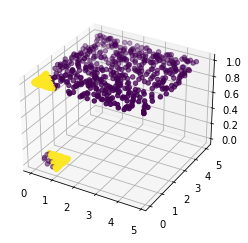

In [22]:
# Testing Split B
X_testB, y_testB = get_test_splitB([500,500])

X_testB = torch.tensor(X_testB).float()
y_testB = torch.tensor(y_testB).view(-1, 1).float()

with torch.no_grad():
    predsB = model(X_testB[:,:2].float(), X_testB[:,2].long())
    total_acc = get_num_correct(y_testB, predsB) / len(X_testB)
print(f"Total Accuracy on test split B: {total_acc}")

# # Comment this line out to see the non-classification predictions.
# predsB = get_pred_class(predsB)

B_indices_wrong = (((predsB != y_testB) == True).nonzero(as_tuple=True)[0]).detach().numpy()

X_testB_orig = unstandardize_data(X_testB, cache["X_testB_mean"], cache["X_testB_std"])
ax = plt.axes(projection='3d')
ax.scatter3D(X_testB_orig[:, 0], X_testB_orig[:, 1], y_testB, c=X_testB[:, 2])
# plt.xlim(0,1)
# plt.ylim(0,1)

tensor([[ 58.5311],
        [ 59.1105],
        [ 54.6160],
        [ 58.8621],
        [ 31.4393],
        [ 59.1484],
        [ 44.1004],
        [ 58.9161],
        [ 31.9954],
        [ 38.1932],
        [ 42.4741],
        [ 40.1539],
        [ 49.9780],
        [ 16.9458],
        [ 57.2122],
        [ 21.5442],
        [ 29.3977],
        [ 38.0699],
        [ 40.8485],
        [ 62.4830],
        [ 57.5940],
        [ 25.1804],
        [ 58.2149],
        [ 62.1053],
        [ 33.0876],
        [ 21.6173],
        [ 51.3786],
        [ 52.1421],
        [ 46.4658],
        [ 52.2818],
        [ 71.2015],
        [ 57.9808],
        [ 34.3811],
        [ 10.7549],
        [ 52.3413],
        [ 29.9810],
        [ 19.1838],
        [ 45.4099],
        [ 40.6065],
        [ 17.5951],
        [ 49.1727],
        [ 41.7943],
        [ 41.7807],
        [ 23.3974],
        [ 64.3992],
        [ 44.0654],
        [ 56.8808],
        [ 63.1908],
        [ 30.0345],
        [ 14.5276],


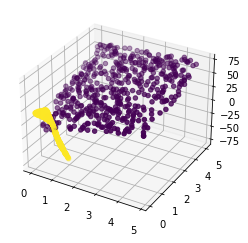

In [24]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_testB_orig[:, 0], X_testB_orig[:, 1], predsB, c=X_testB[:, 2])
print(predsB)
# plt.xlim(0,1)
# plt.ylim(0,1)

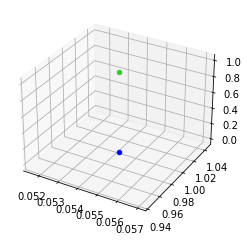

In [18]:
ax = plt.axes(projection='3d')
X_wrong = X_testB_orig[B_indices_wrong]
y_wrong = y_testB[B_indices_wrong]
ax.scatter3D(X_wrong[:, 0], X_wrong[:, 1], y_wrong, c='limegreen')
ax.scatter3D(X_wrong[:, 0], X_wrong[:, 1], predsB[B_indices_wrong], c='blue')

Total Accuracy on test split C: 0.9649999737739563


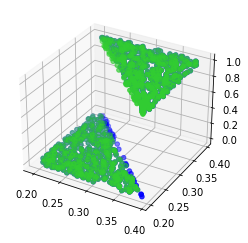

In [19]:
# Testing Split C
X_testC, y_testC = get_test_splitC(1000)

# X_testC_orig = unnormalize_data(X_testC, cache["X_testC_mean"], cache["X_testC_std"])

X_testC = torch.tensor(X_testC).float()
y_testC = torch.tensor(y_testC).view(-1, 1).float()

with torch.no_grad():
    predsC = model(X_testC[:,:2].float(), X_testC[:,2].long())
    total_acc = get_num_correct(y_testC, predsC) / len(X_testC)
    
# Comment this line out to see the non-classification predictions.
predsC = get_pred_class(predsC)

print(f"Total Accuracy on test split C: {total_acc}")

X_testC_orig = unstandardize_data(X_testC, cache["X_testC_mean"], cache["X_testC_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_testC_orig[:, 0], X_testC_orig[:, 1], y_testC, c='limegreen')
ax.scatter3D(X_testC_orig[:, 0], X_testC_orig[:, 1], predsC, c='blue')